In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

# Обработка данных, графики (EDA)

In [3]:
# Просматриваю какие столбцы в тест данных
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()

,ApplicationDate,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,...,EmploymentStatus,EducationLevel,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,2010-06-26,27.0,66829.0,549.0,17290.0,60.0,Divorced,1.0,Rent,1095.0,...,Employed,Associate,4.0,35067.0,0.257790,0.251465,508.970230,0.288013,0.0,66.176500
1,1996-09-23,55.0,172147.0,850.0,16110.0,36.0,Widowed,1.0,Mortgage,211.0,...,Employed,High School,33.0,27001.0,0.086110,0.093173,514.675859,0.050585,1.0,28.495737
2,2015-01-19,51.0,300000.0,850.0,38436.0,36.0,Married,0.0,Mortgage,546.0,...,Employed,Bachelor,28.0,278382.0,0.108436,0.115443,1268.276385,0.072571,1.0,34.488104
3,1981-05-12,25.0,34683.0,847.0,19186.0,48.0,Married,0.0,Other,153.0,...,Employed,High School,0.0,9224.0,0.100686,0.112822,498.505187,0.225415,1.0,36.910753
4,1995-05-07,55.0,300000.0,850.0,30437.0,48.0,Single,2.0,Rent,562.0,...,Employed,Bachelor,31.0,4502.0,0.110437,0.089037,756.035156,0.052721,1.0,31.347091


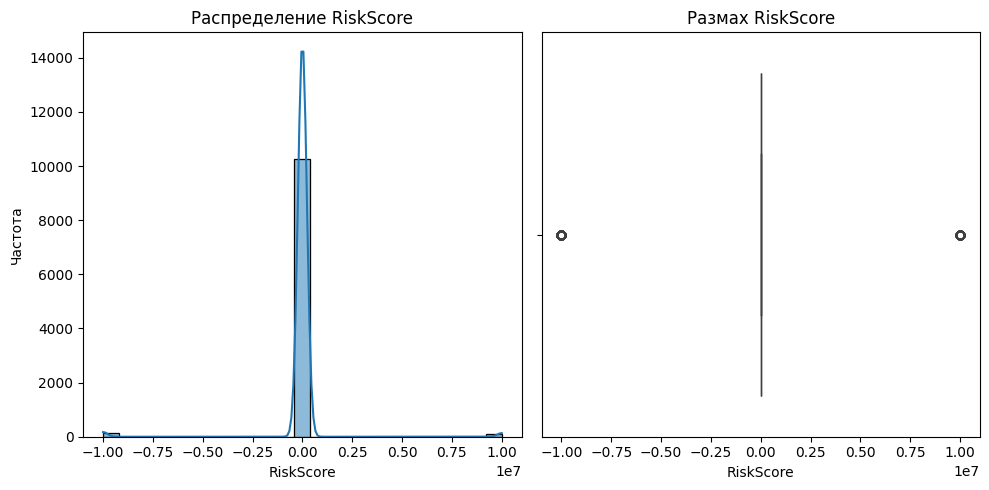

In [4]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(train_df['RiskScore'], kde=True, bins=25)
plt.title('Распределение RiskScore')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
sns.boxplot(x=train_df['RiskScore'])
plt.title('Размах RiskScore')

plt.tight_layout()
plt.show()

In [5]:
train_df[train_df['RiskScore'] > 100]['RiskScore'].sort_values()

,RiskScore
237,10000000.0
398,10000000.0
657,10000000.0
1168,10000000.0
1253,10000000.0
...,...
9791,10000000.0
9929,10000000.0
10586,10000000.0
10601,10000000.0


In [6]:
train_df[train_df['RiskScore'] < 0]['RiskScore'].sort_values()

,RiskScore
33,-9999999.0
56,-9999999.0
83,-9999999.0
183,-9999999.0
198,-9999999.0
...,...
9148,-9999999.0
9263,-9999999.0
9710,-9999999.0
9959,-9999999.0


Основные значения RiskScore находятся в диапозоне от 0 до 100, найденные выбросы будем считать "мусором". Так же проверим, есть ли null значения.

In [7]:
null_count = train_df['RiskScore'].isnull().sum()
print(f"Количество пропусков в 'RiskScore': {null_count}")
all_rows = train_df['RiskScore'].notnull().sum
print(f"Доля пропусков: {null_count / len(train_df):.2%}")

Количество пропусков в 'RiskScore': 530
Доля пропусков: 4.81%


Можем пренебречь 4.81% и удалить такие строки + удалим "мусор".

In [8]:
initial_count = len(train_df)
train_df = train_df[(train_df['RiskScore'] >= 0) & (train_df['RiskScore'] <= 100)]

train_df = train_df.dropna(subset=['RiskScore'])

print("\nАнализ пропусков по всем признакам:")
null_analysis = pd.DataFrame({
    'Количество null': train_df.isnull().sum(),
    'Процент null': (train_df.isnull().mean() * 100).round(2)
}).sort_values('Количество null', ascending=False)


null_analysis.style.format({'Процент null': '{:.2f}%'})


Анализ пропусков по всем признакам:


,Количество null,Процент null
CreditScore,485,4.72%
BankruptcyHistory,485,4.72%
MonthlyDebtPayments,485,4.72%
LoanAmount,485,4.72%
NetWorth,485,4.72%
BaseInterestRate,485,4.72%
TotalAssets,485,4.72%
LoanPurpose,485,4.72%
CheckingAccountBalance,485,4.72%
AnnualIncome,0,0.00%


Теперь RiskScore не имеет пустых значений, перепроверим графики, что убедиться, что размах нормализовался.

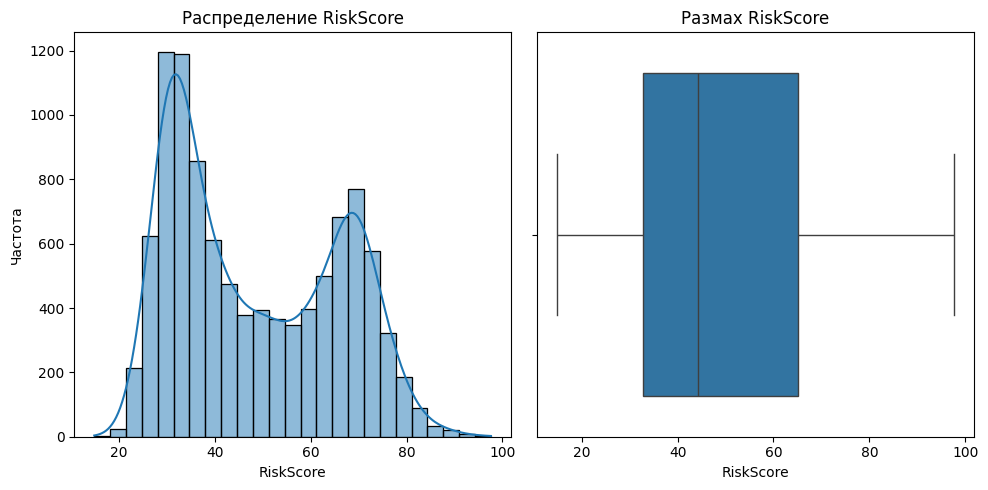

In [9]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(train_df['RiskScore'], kde=True, bins=25)
plt.title('Распределение RiskScore')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
sns.boxplot(x=train_df['RiskScore'])
plt.title('Размах RiskScore')

plt.tight_layout()
plt.show()

Теперь остальные столбцы с пустыми значениями дополним средним. Для начала разобьём их на категории (числовые и категориальные)

In [10]:
numeric_features = train_df.drop(columns=['RiskScore']).select_dtypes(np.number).columns.tolist()
categorical_features = train_df.select_dtypes(include=['object', 'category']).columns.tolist()

print("Числовые признаки:", numeric_features)
print("Категориальные признаки:", categorical_features)

Числовые признаки: ['Age', 'AnnualIncome', 'CreditScore', 'LoanAmount', 'LoanDuration', 'NumberOfDependents', 'MonthlyDebtPayments', 'CreditCardUtilizationRate', 'NumberOfOpenCreditLines', 'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'BankruptcyHistory', 'PreviousLoanDefaults', 'PaymentHistory', 'LengthOfCreditHistory', 'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets', 'TotalLiabilities', 'MonthlyIncome', 'UtilityBillsPaymentHistory', 'JobTenure', 'Experience', 'NetWorth', 'BaseInterestRate', 'InterestRate', 'MonthlyLoanPayment', 'TotalDebtToIncomeRatio', 'LoanApproved']
Категориальные признаки: ['ApplicationDate', 'MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose', 'EmploymentStatus', 'EducationLevel']


In [11]:
# Заполнение средним по столбцу для числовых
train_df[numeric_features] = train_df[numeric_features].fillna(
    train_df[numeric_features].mean()
)
# Модальное заполнение для категориальных
for feat in categorical_features:
    train_df[feat] = train_df[feat].fillna(
        train_df[feat].mode()[0]
    )
initial_rows = len(train_df)
train_df = train_df.drop_duplicates()
print(f"Удалено дубликатов в train_df: {initial_rows - len(train_df)}")

Удалено дубликатов в train_df: 484


In [12]:
print("Пропуски в train_df:")
train_df.isnull().sum()

Пропуски в train_df:


,0
ApplicationDate,0
Age,0
AnnualIncome,0
CreditScore,0
LoanAmount,0
LoanDuration,0
MaritalStatus,0
NumberOfDependents,0
HomeOwnershipStatus,0
MonthlyDebtPayments,0


Продолжая подготовку данных, переведём наши категориальные признаки в числовые. Для начала посмотрим сколько уникальных значений, у категориальных признаков.

In [13]:
train_df[categorical_features].nunique()

,0
ApplicationDate,9788
MaritalStatus,4
HomeOwnershipStatus,4
LoanPurpose,5
EmploymentStatus,3
EducationLevel,5


У ApplicationDate, очень много уникальных значений, разобьём её на год, месяц, день. То есть вместо 1 категориального, получим 3 числовых.

In [14]:
train_df = train_df.copy()
train_df['ApplicationDate'] = pd.to_datetime(train_df['ApplicationDate'])

train_df['Application_Year'] = train_df['ApplicationDate'].dt.year
train_df['Application_Month'] = train_df['ApplicationDate'].dt.month
train_df['Application_Day'] = train_df['ApplicationDate'].dt.day

train_df = train_df.drop(columns=['ApplicationDate'])


In [15]:
test_df['ApplicationDate'] = pd.to_datetime(test_df['ApplicationDate'])

test_df['Application_Year'] = test_df['ApplicationDate'].dt.year
test_df['Application_Month'] = test_df['ApplicationDate'].dt.month
test_df['Application_Day'] = test_df['ApplicationDate'].dt.day

test_df = test_df.drop(columns=['ApplicationDate'])

In [16]:
categorical_cols = ['MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose', 'EmploymentStatus', 'EducationLevel']

for col in categorical_cols:
    unique_values = train_df[col].unique()
    print(f"\n{col}")
    print(f"Уникальные значения ({unique_values}")


MaritalStatus
Уникальные значения (['Divorced' 'Widowed' 'Married' 'Single']

HomeOwnershipStatus
Уникальные значения (['Rent' 'Mortgage' 'Other' 'Own']

LoanPurpose
Уникальные значения (['Education' 'Home' 'Debt Consolidation' 'Auto' 'Other']

EmploymentStatus
Уникальные значения (['Employed' 'Self-Employed' 'Unemployed']

EducationLevel
Уникальные значения (['Associate' 'High School' 'Bachelor' 'Master' 'Doctorate']


Признаки номинальные (не имеют никакого порядка по значениям). Значит можно применить метод One-hot-encoding.

In [17]:
def one_hot_encoding(df, categorical_cols):
    temp = df.copy()
    dummies = pd.get_dummies(temp[categorical_cols],
                              prefix=categorical_cols,
                             dtype='int8')

    result = pd.concat([temp.drop(columns=categorical_cols), dummies], axis=1)
    return result

In [18]:
categorical_cols = ['MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose',
                   'EmploymentStatus', 'EducationLevel']

train_df = one_hot_encoding(train_df, categorical_cols)
test_df = one_hot_encoding(test_df, categorical_cols)

train_df.head()


,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,NumberOfDependents,MonthlyDebtPayments,CreditCardUtilizationRate,NumberOfOpenCreditLines,NumberOfCreditInquiries,...,LoanPurpose_Home,LoanPurpose_Other,EmploymentStatus_Employed,EmploymentStatus_Self-Employed,EmploymentStatus_Unemployed,EducationLevel_Associate,EducationLevel_Bachelor,EducationLevel_Doctorate,EducationLevel_High School,EducationLevel_Master
0,27.0,66829.0,549.0,17290.0,60.0,1.0,1095.0,0.151985,2.0,1.0,...,0,0,1,0,0,1,0,0,0,0
1,55.0,172147.0,850.0,16110.0,36.0,1.0,211.0,0.175693,3.0,0.0,...,1,0,1,0,0,0,0,0,1,0
2,51.0,300000.0,850.0,38436.0,36.0,0.0,546.0,0.444605,3.0,0.0,...,0,0,1,0,0,0,1,0,0,0
3,25.0,34683.0,847.0,19186.0,48.0,0.0,153.0,0.188452,7.0,0.0,...,0,0,1,0,0,0,0,0,1,0
4,55.0,300000.0,850.0,30437.0,48.0,2.0,562.0,0.273431,3.0,1.0,...,0,0,1,0,0,0,1,0,0,0


Теперь все признаки в наших даннах числовые.

# Графики зависимостей признаков от частоты

In [ ]:
def plot_distribution(df, column_name, bins=25, figsize=(10, 5)):
    plt.figure(figsize=figsize)

    plt.subplot(1, 2, 1)
    sns.histplot(df[column_name], kde=True, bins=bins)
    plt.title(f'Распределение {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Частота')

    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[column_name])
    plt.title(f'Размах {column_name}')
    plt.xlabel(column_name)

    plt.tight_layout()
    plt.show()

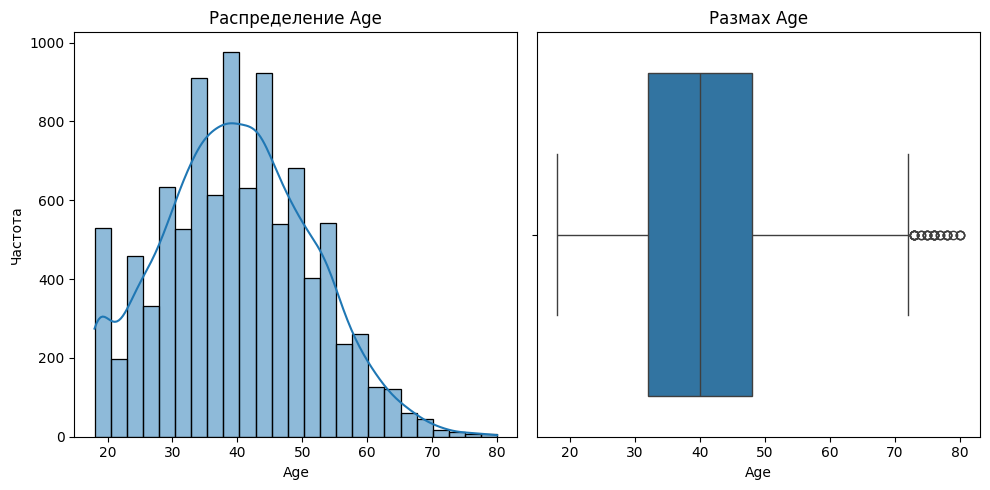

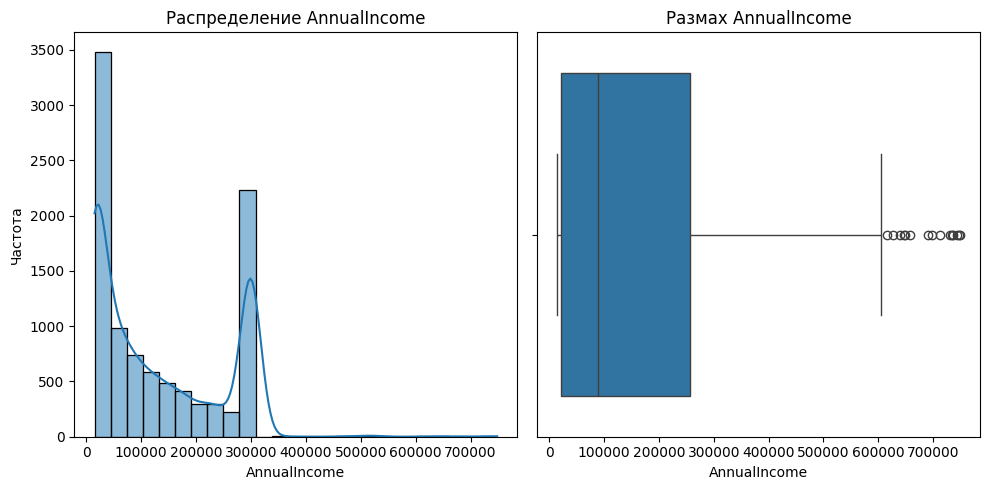

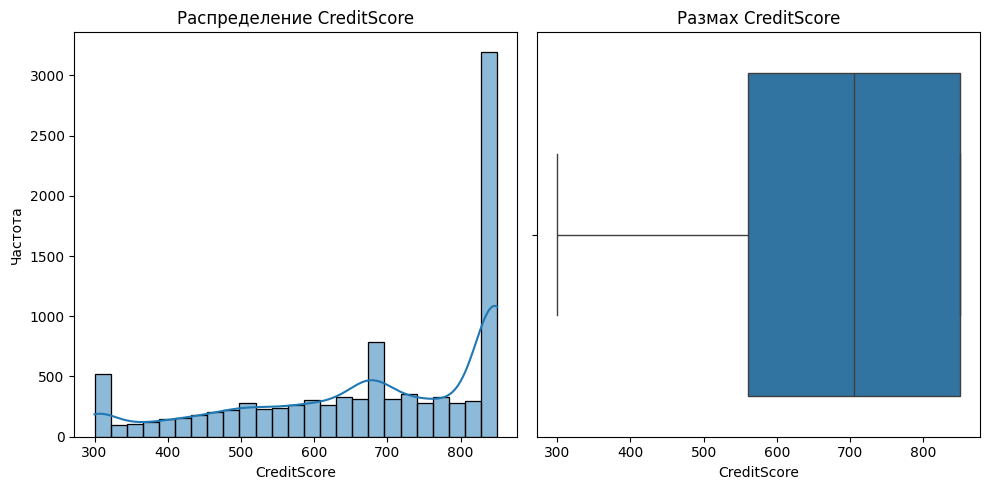

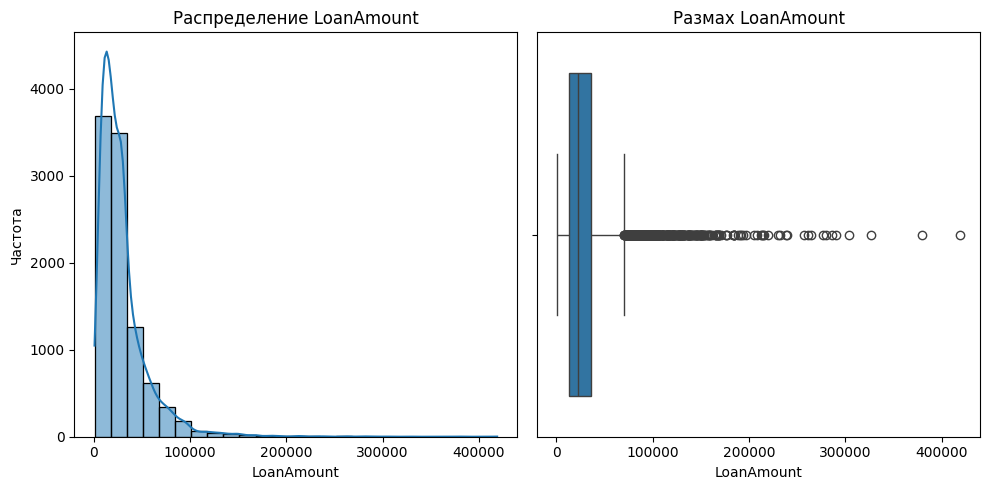

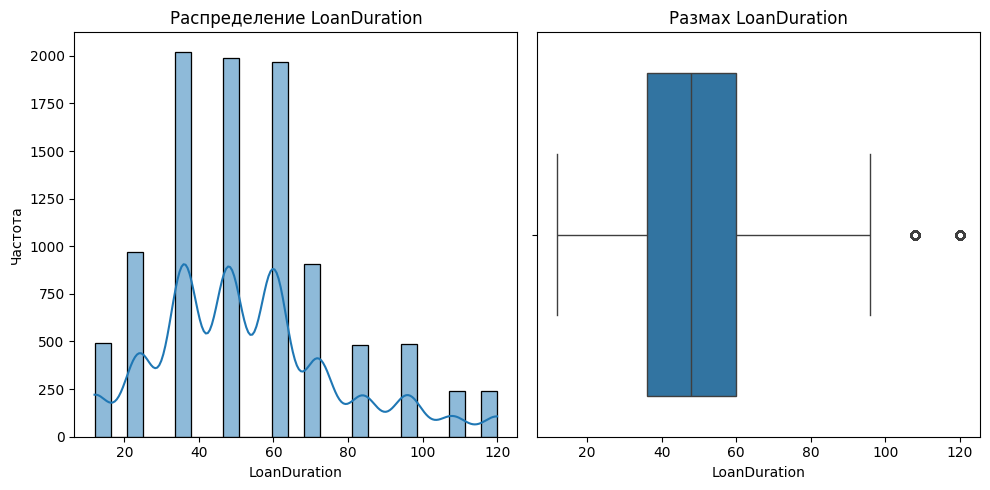

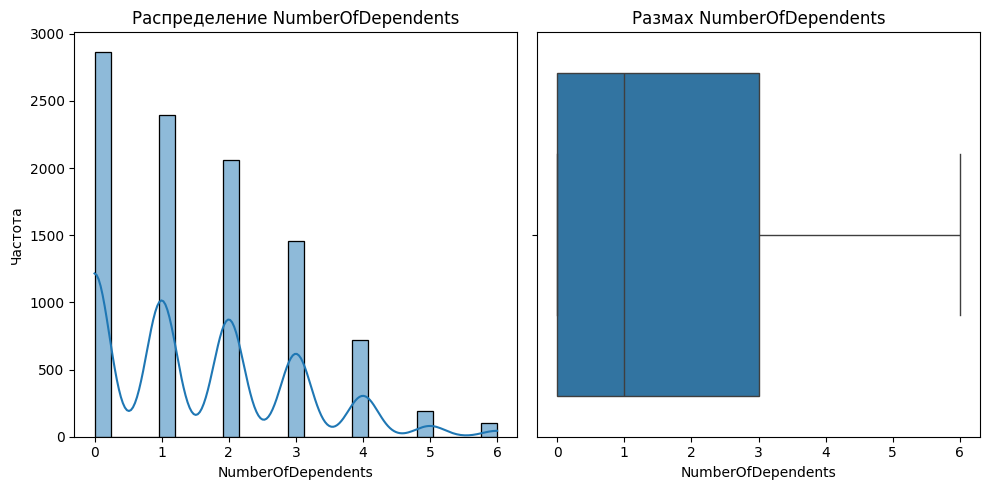

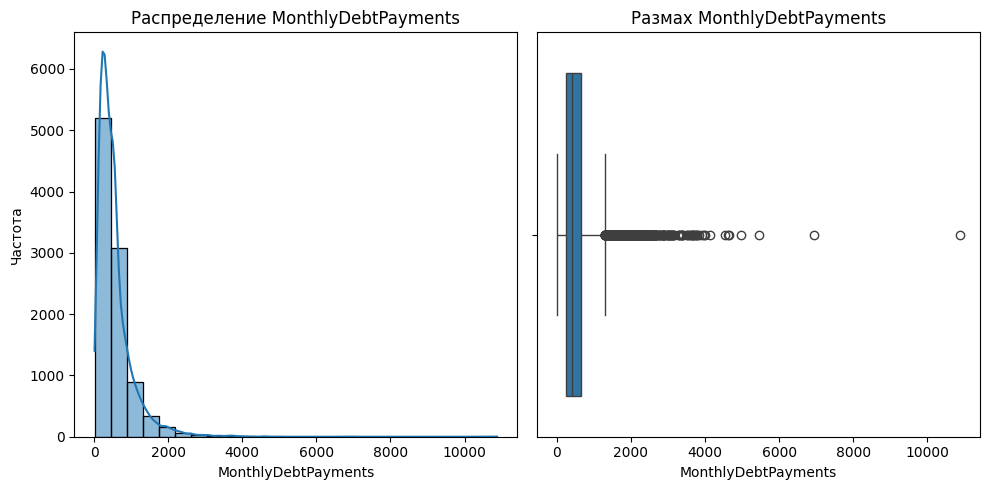

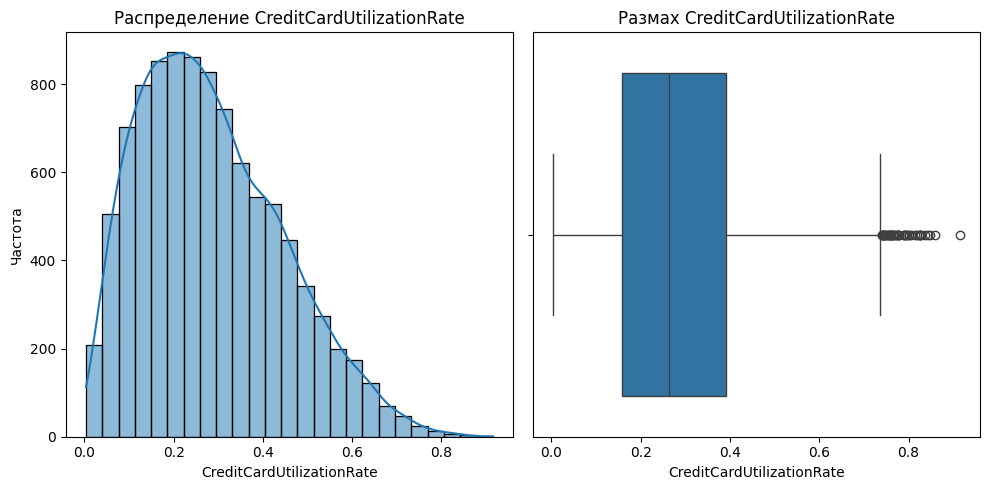

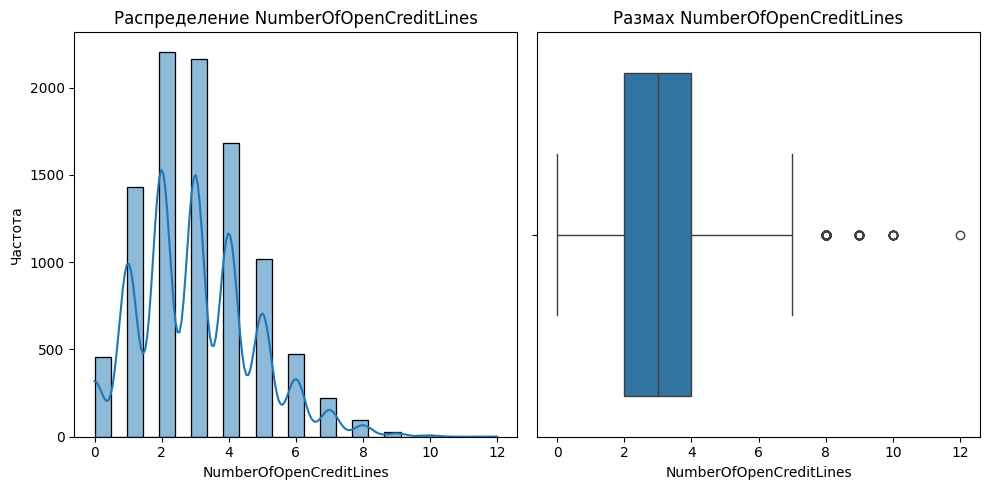

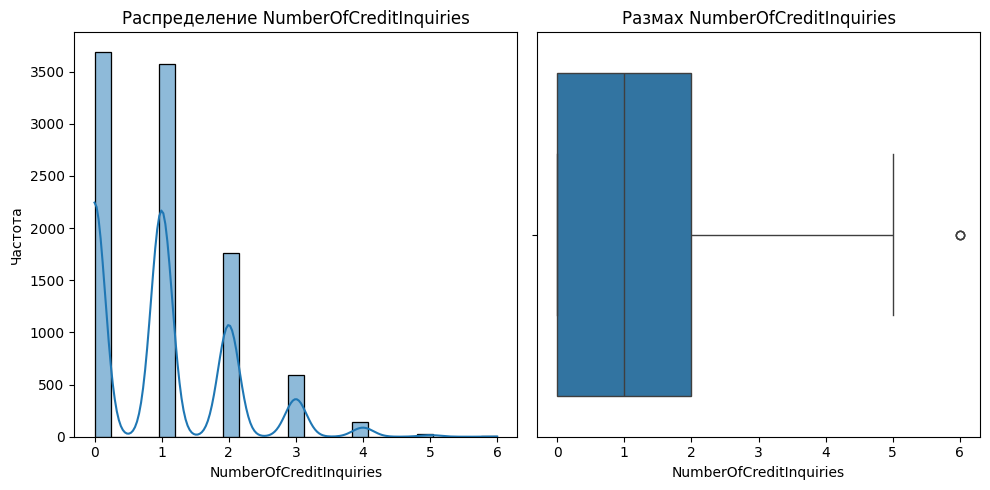

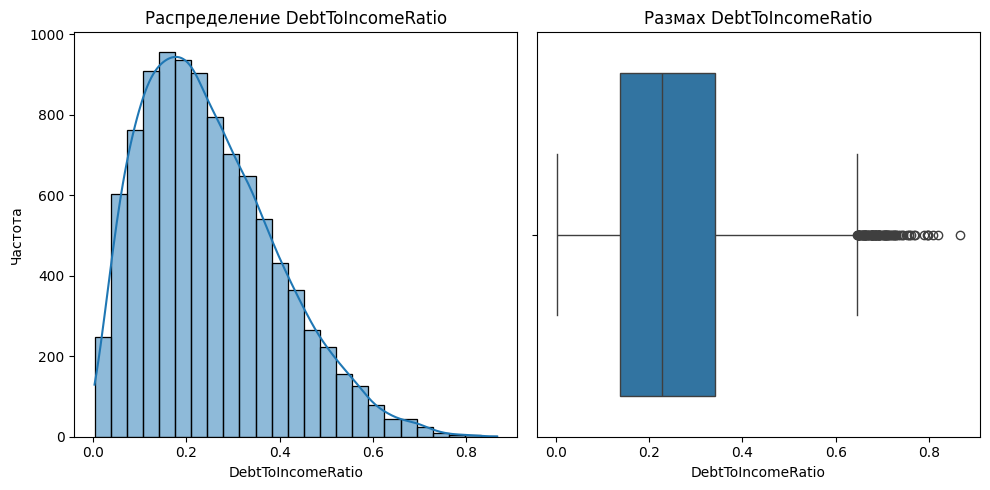

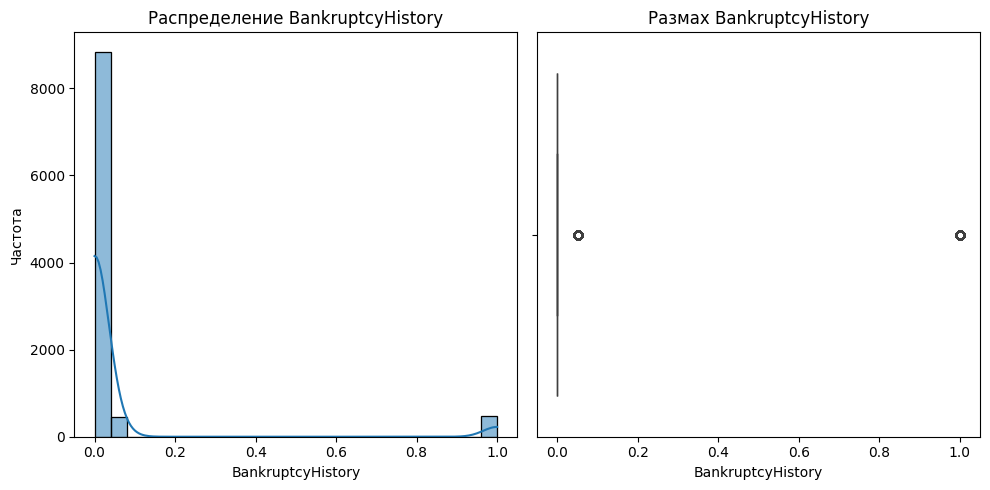

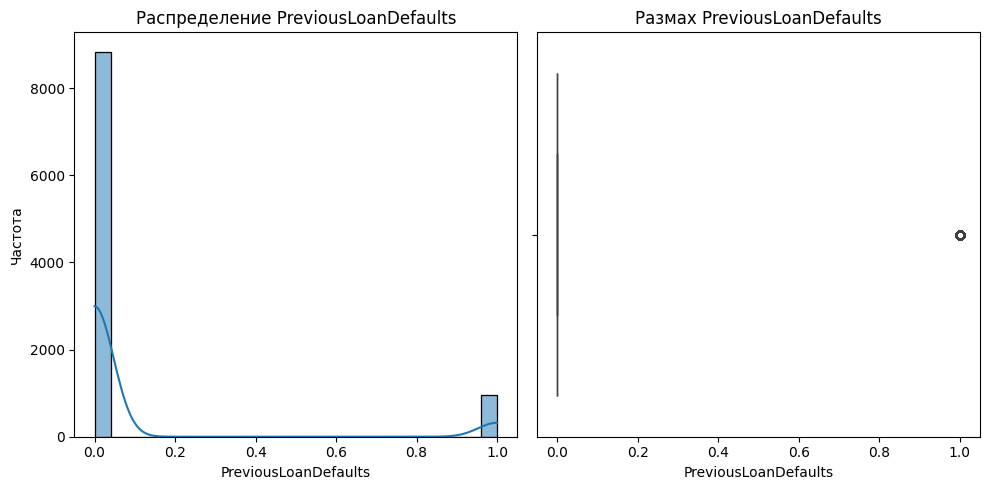

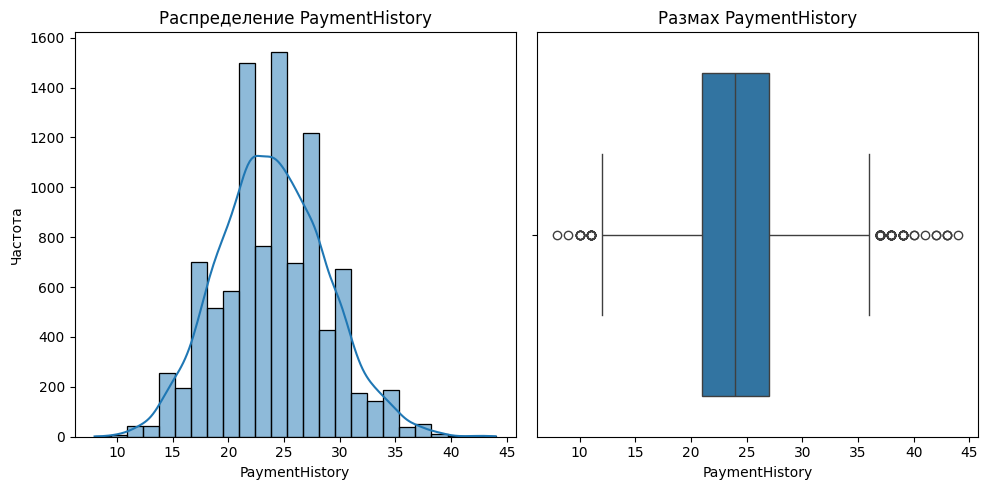

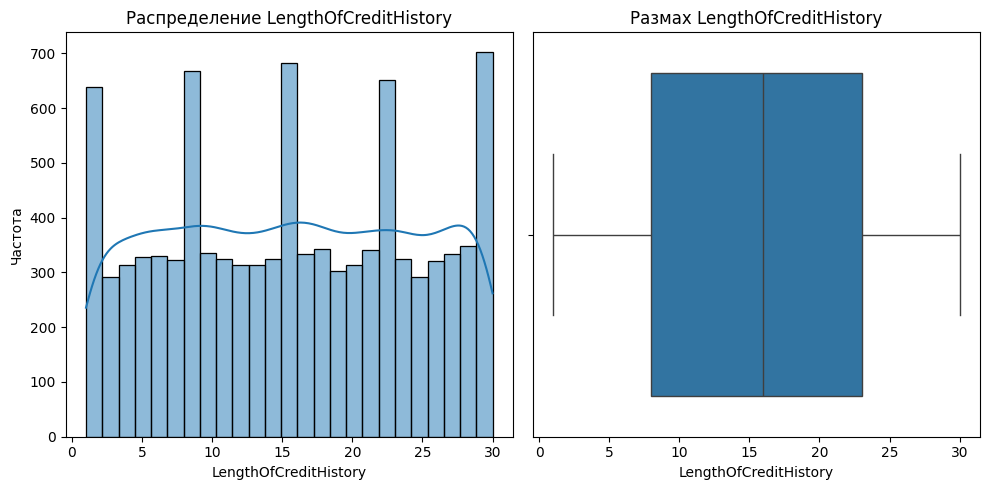

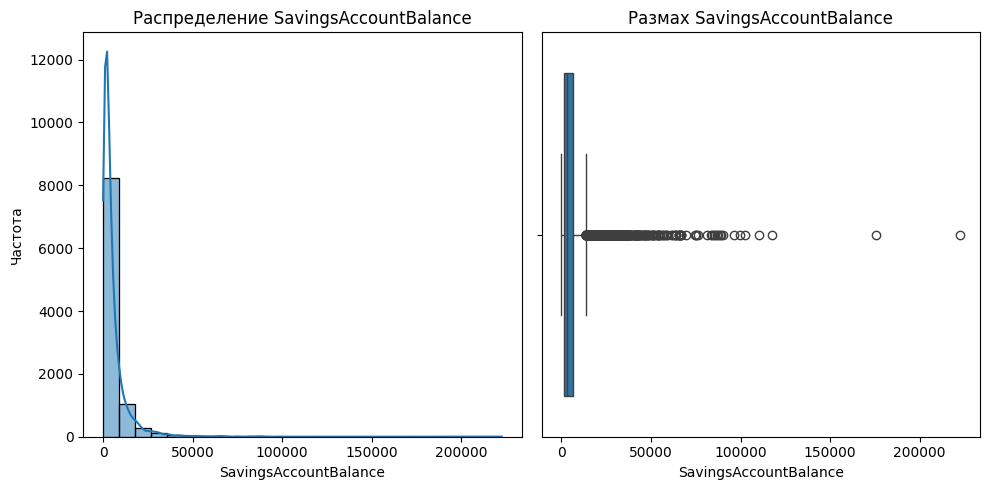

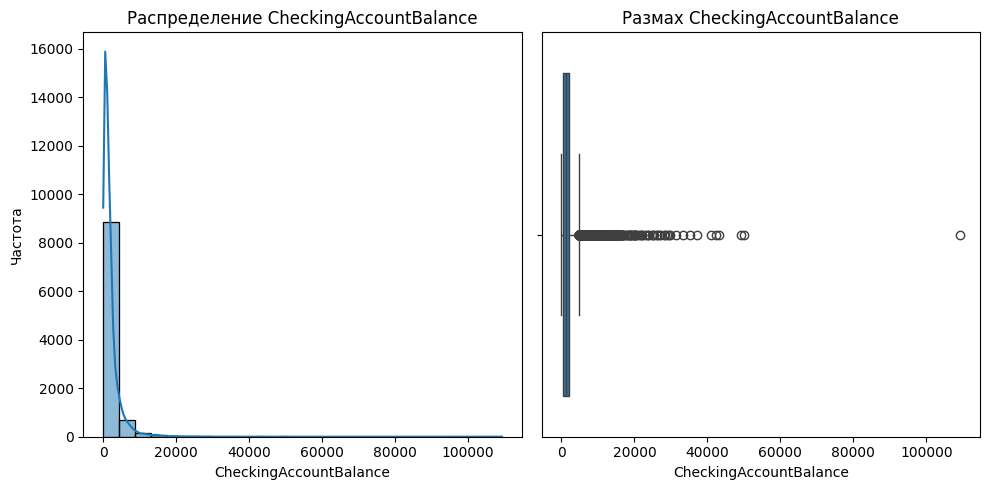

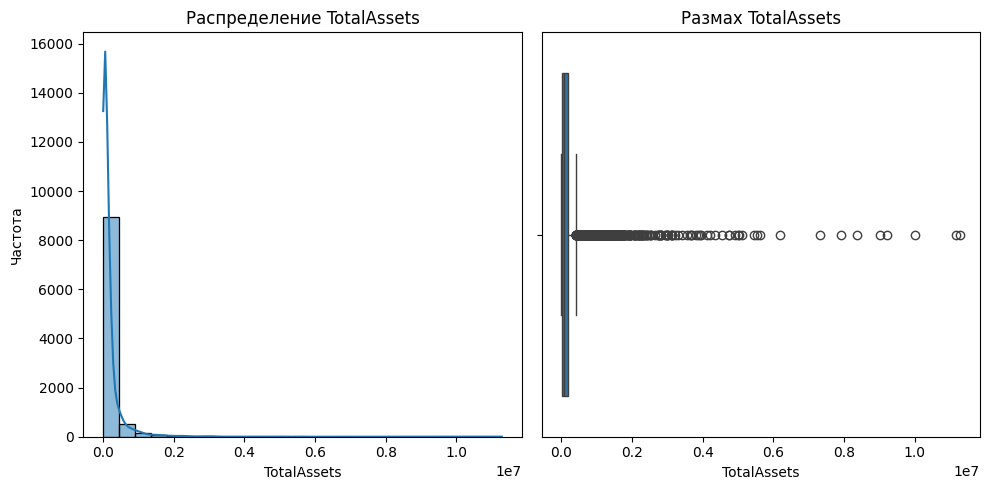

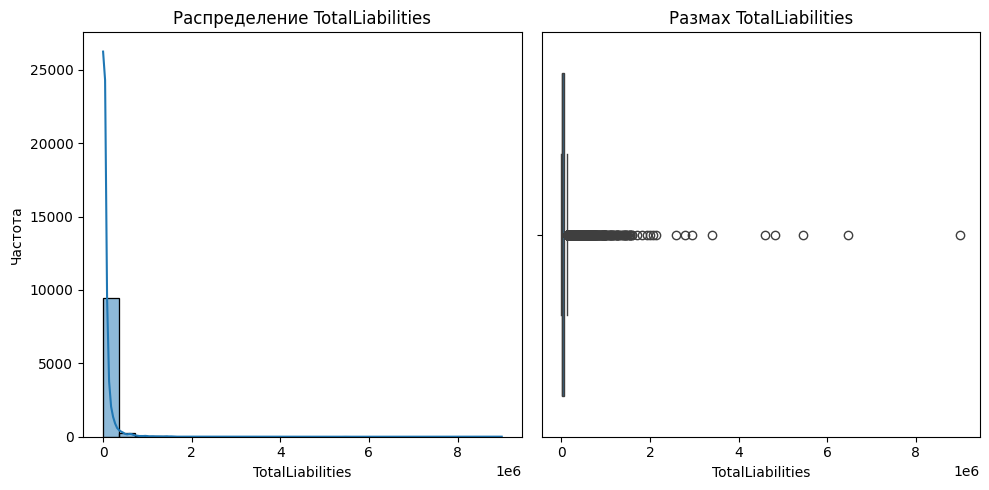

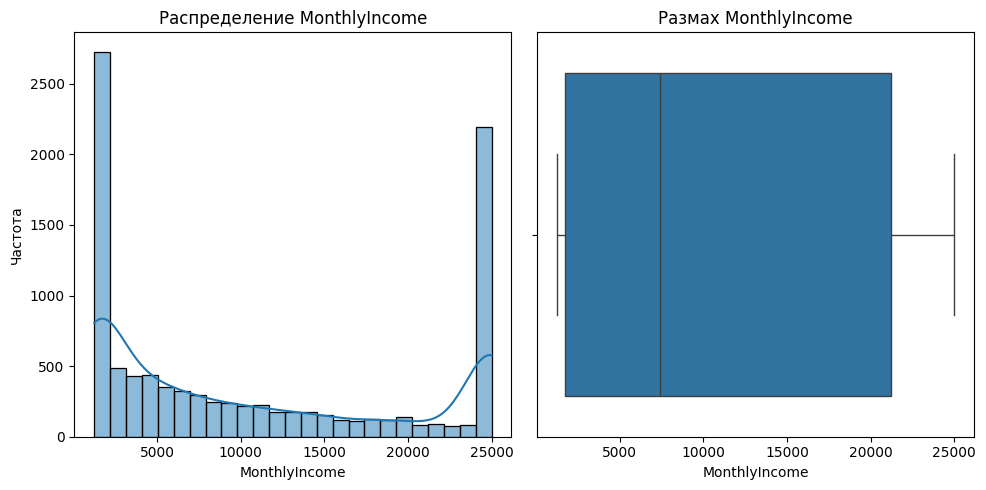

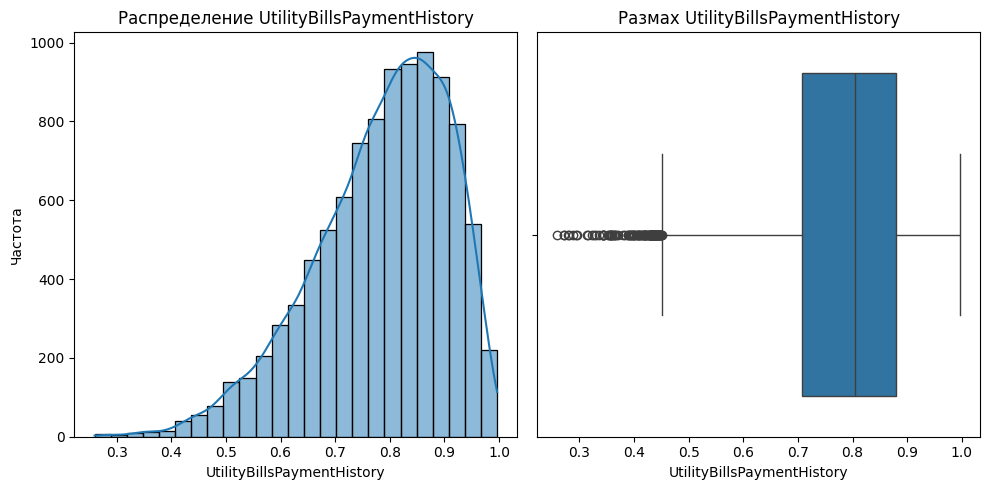

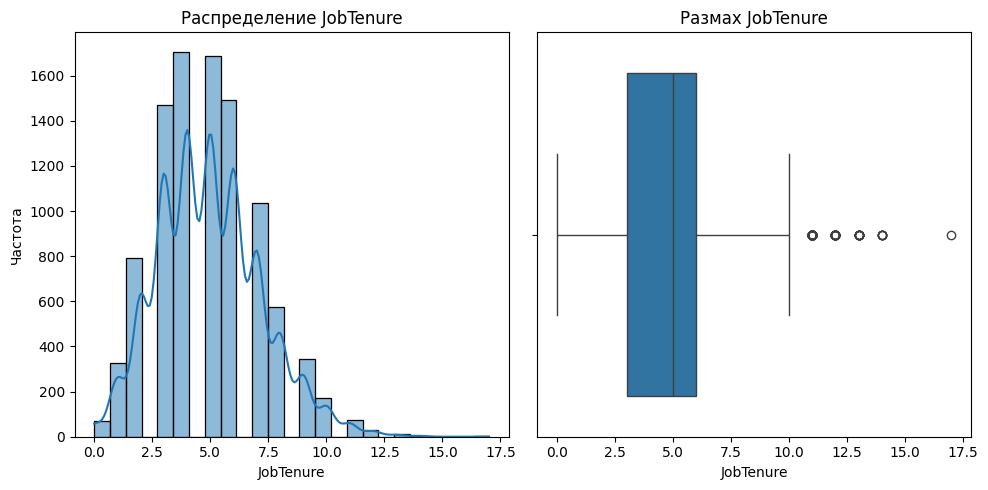

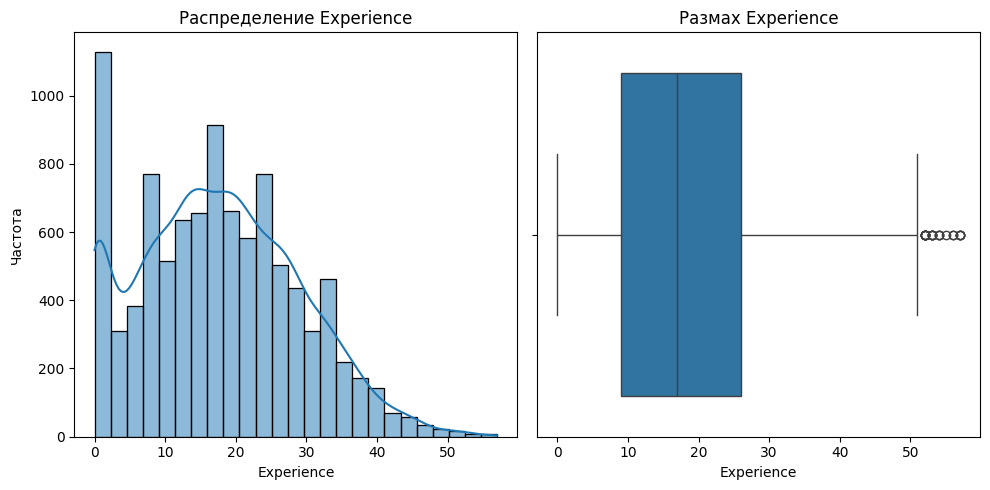

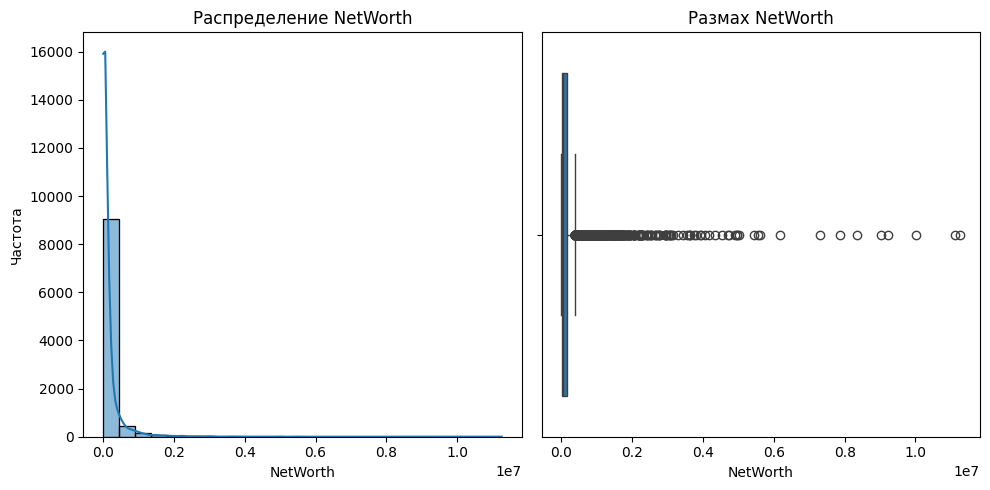

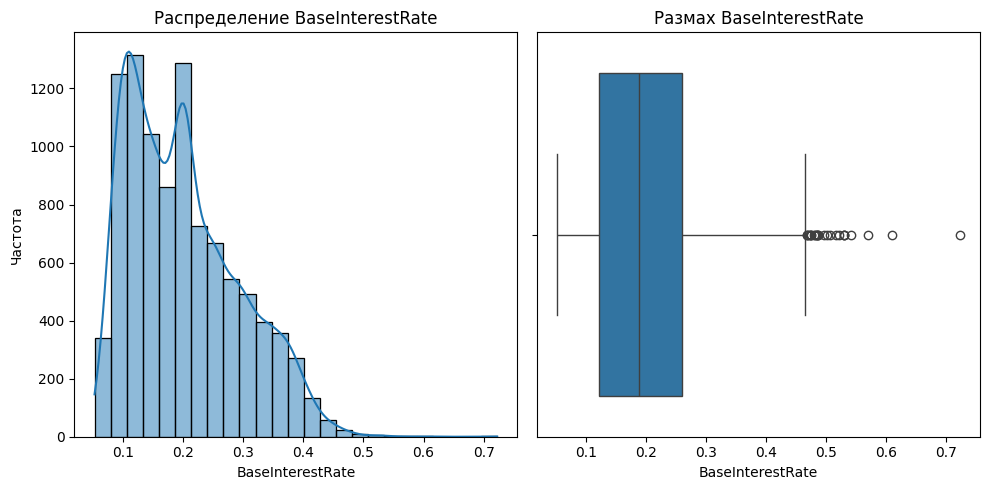

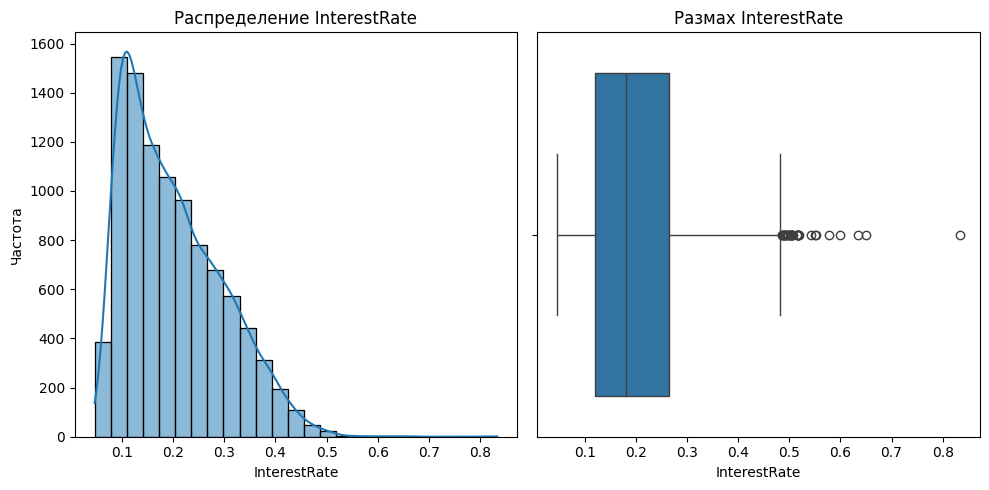

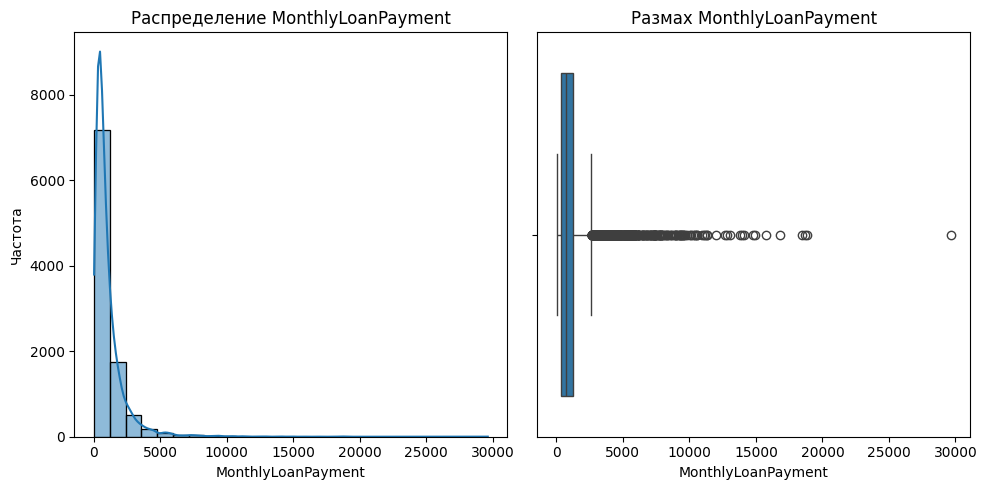

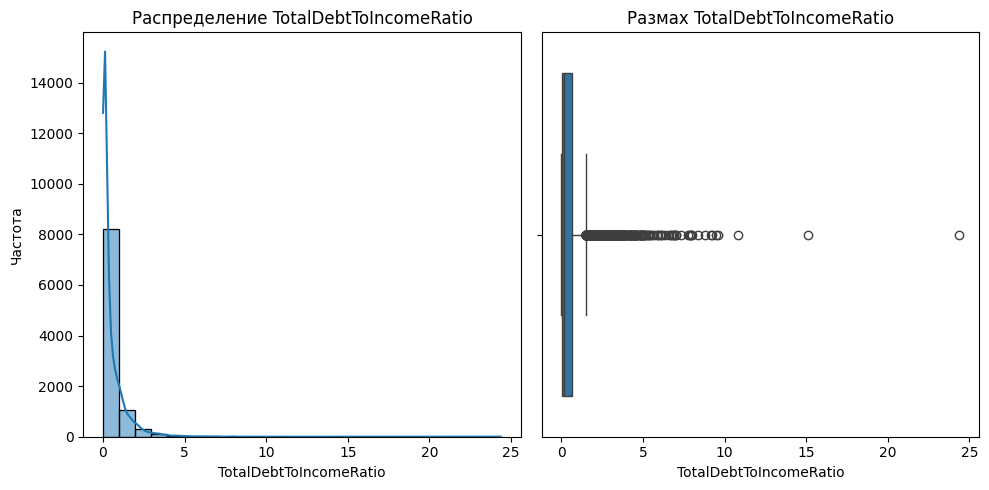

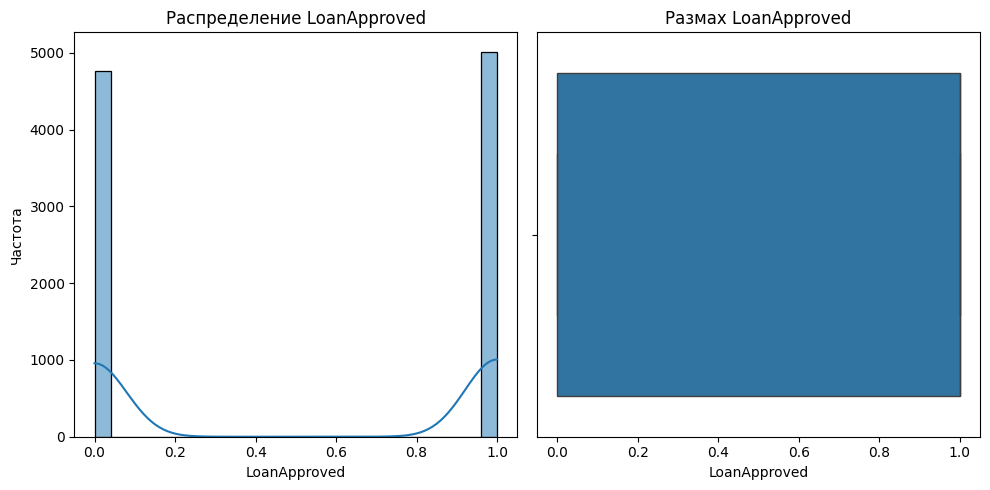

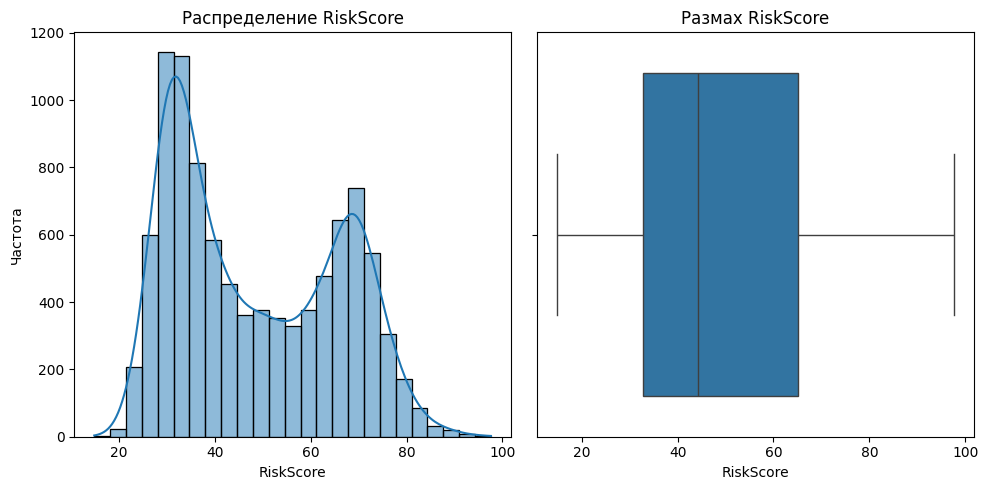

In [ ]:
numeric_features = [col for col in train_df.select_dtypes(np.number).columns
                   if '_' not in col]
for feature in numeric_features:
    plot_distribution(train_df, feature)

# Продолжение обработки данных, матрица корреляций, зависимости.

In [20]:
copy_train_df = train_df.copy()
copy_test_df = test_df.copy()

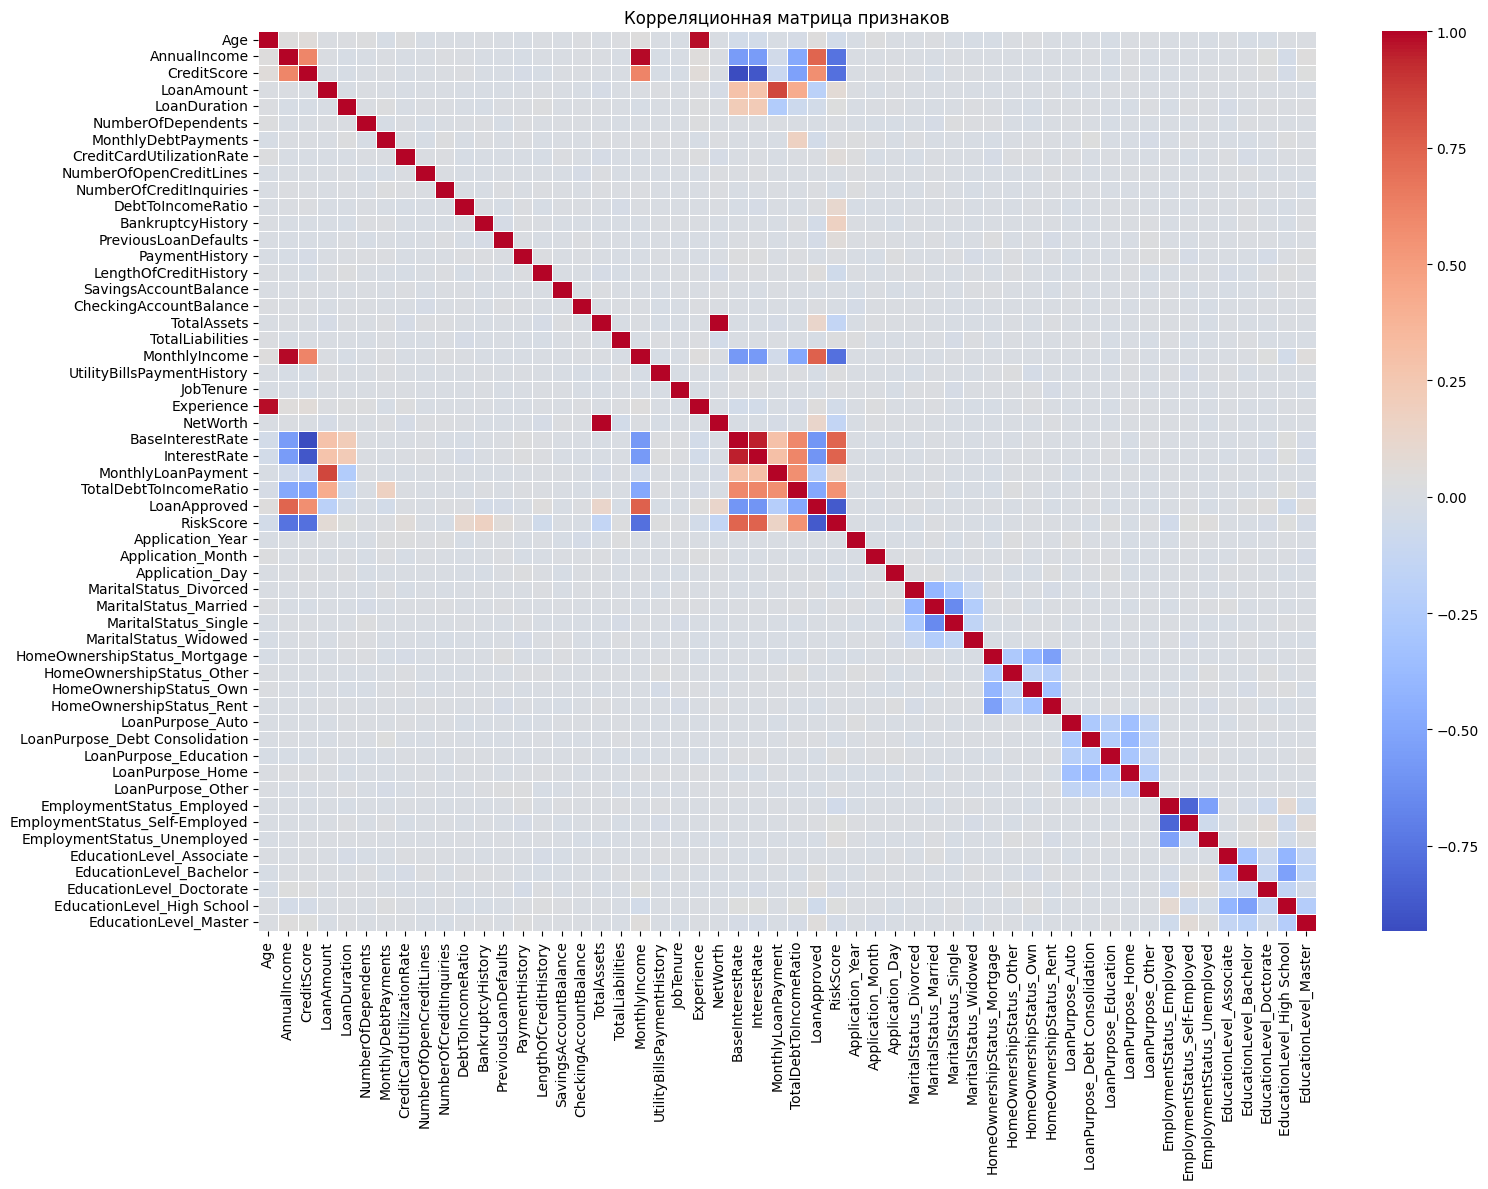

In [32]:
corr_matrix = copy_train_df.corr(numeric_only=True)

plt.figure(figsize=(16, 12))

sns.heatmap(corr_matrix,
            cmap='coolwarm',
            annot=False,
            fmt='.2f',
            linewidths=0.5)

plt.title('Корреляционная матрица признаков')
plt.tight_layout()
plt.show()

Чтобы избежать мультиколлинеарности, рассмотрим наиболее коррелирующие признаки и проведём анализ.

In [ ]:
def visual_matrix(matrix, ):


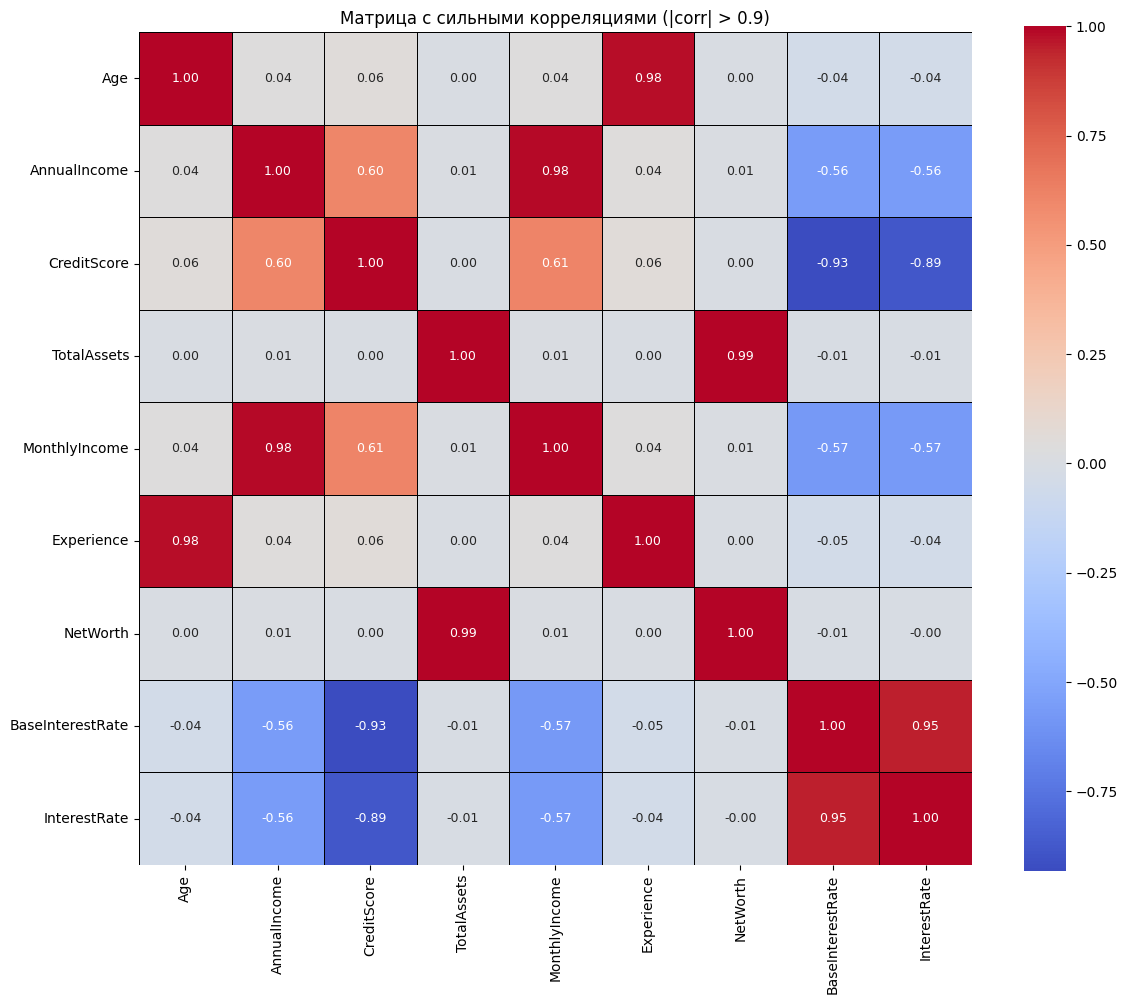

In [39]:
np.fill_diagonal(corr_matrix.values, 0)
high_corr_features = corr_matrix.columns[(np.abs(corr_matrix) > 0.9).any()]
filtered_corr = corr_matrix.loc[high_corr_features, high_corr_features]
np.fill_diagonal(filtered_corr.values, 1)

plt.figure(figsize=(12, 10))
sns.heatmap(filtered_corr,
            cmap='coolwarm',
            annot=True,
            fmt='.2f',
            linewidths=0.5,
            linecolor='black',
            square=True,
            cbar=True,
            annot_kws={"size": 9})

plt.title('Матрица с сильными корреляциями (|corr| > 0.9)')
plt.tight_layout()
plt.show()

По матрице видно, что у нас есть 4 максимально коррелирующих признака (Age:Experience, AnnualIncome:MonthlyIncome, TotalAssets:NetWorth, BaseInterestRate:InterestRate)

Будем оставлять те признаки, которые больше всего коррелируют с RiskScore.

In [48]:
def plot_multiple_correlations(df: pd.DataFrame,
                             correlated_pairs: list,
                             target_col: str = 'RiskScore',
                             figsize: tuple = (15, 8)) -> list:
    n_pairs = len(correlated_pairs)
    cols_to_drop = []

    plt.figure(figsize=figsize)

    for i, (col1, col2) in enumerate(correlated_pairs, 1):
        plt.subplot(1, n_pairs, i)

        corr_matrix = df[[col1, col2, target_col]].corr()

        corr1 = abs(corr_matrix.loc[col1, target_col])
        corr2 = abs(corr_matrix.loc[col2, target_col])

        if corr1 > corr2:
            cols_to_drop.append(col2)
            title = f"Удалить '{col2}'\n({col1}: {corr1:.4f} vs {col2}: {corr2:.4f})"
        else:
            cols_to_drop.append(col1)
            title = f"Удалить '{col1}'\n({col2}: {corr2:.4f} vs {col1}: {corr1:.4f})"

        sns.heatmap(
            corr_matrix,
            cmap='coolwarm',
            annot=True,
            fmt='.4f',
            linewidths=0.5,
            linecolor='black',
            square=True,
            cbar=False,
            annot_kws={"size": 10}
        )
        plt.title(title, fontsize=10)

    plt.tight_layout()
    plt.show()

    return cols_to_drop

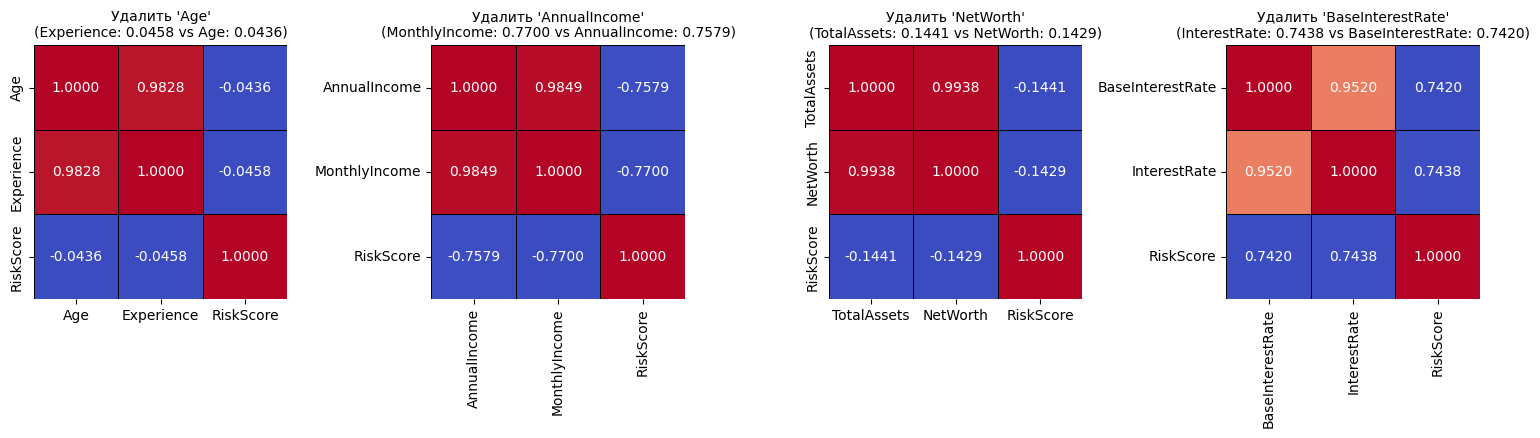


Столбцы для удаления: ['Age', 'AnnualIncome', 'NetWorth', 'BaseInterestRate']


In [49]:
correlated_pairs = [
    ('Age', 'Experience'),
    ('AnnualIncome', 'MonthlyIncome'),
    ('TotalAssets', 'NetWorth'),
    ('BaseInterestRate', 'InterestRate')
]

cols_to_remove = plot_multiple_correlations(copy_train_df, correlated_pairs)
print(f"\nСтолбцы для удаления: {cols_to_remove}")

In [51]:
copy_test_df.drop(columns=cols_to_remove, inplace=True, errors='ignore')
copy_train_df.drop(columns=cols_to_remove, inplace=True, errors='ignore')

In [52]:
copy_train_df.head()

,CreditScore,LoanAmount,LoanDuration,NumberOfDependents,MonthlyDebtPayments,CreditCardUtilizationRate,NumberOfOpenCreditLines,NumberOfCreditInquiries,DebtToIncomeRatio,BankruptcyHistory,...,LoanPurpose_Home,LoanPurpose_Other,EmploymentStatus_Employed,EmploymentStatus_Self-Employed,EmploymentStatus_Unemployed,EducationLevel_Associate,EducationLevel_Bachelor,EducationLevel_Doctorate,EducationLevel_High School,EducationLevel_Master
0,549.0,17290.0,60.0,1.0,1095.0,0.151985,2.0,1.0,0.168542,0.0,...,0,0,1,0,0,1,0,0,0,0
1,850.0,16110.0,36.0,1.0,211.0,0.175693,3.0,0.0,0.141553,0.0,...,1,0,1,0,0,0,0,0,1,0
2,850.0,38436.0,36.0,0.0,546.0,0.444605,3.0,0.0,0.030987,1.0,...,0,0,1,0,0,0,1,0,0,0
3,847.0,19186.0,48.0,0.0,153.0,0.188452,7.0,0.0,0.379843,0.0,...,0,0,1,0,0,0,0,0,1,0
4,850.0,30437.0,48.0,2.0,562.0,0.273431,3.0,1.0,0.068659,0.0,...,0,0,1,0,0,0,1,0,0,0


# Графики зависимостей признаков от целевой переменной (RiskScore)

In [72]:
def visualize_features_vs_target(df: pd.DataFrame,
                               target_col: str = 'RiskScore',
                               figsize: tuple = (15, 30),
                               cols_per_row: int = 3):
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    numeric_cols = numeric_cols.drop(target_col, errors='ignore')

    n_cols = min(cols_per_row, len(numeric_cols))
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()

    for i, col in enumerate(numeric_cols):
        ax = axes[i]
        sns.regplot(
            data=df,
            x=col,
            y=target_col,
            ax=ax,
            scatter_kws={'alpha': 0.6},
            line_kws={'color': 'red'}
        )
        ax.set_title(f'{target_col} vs {col}')
        ax.set_xlabel(col)
        ax.set_ylabel(target_col)

    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

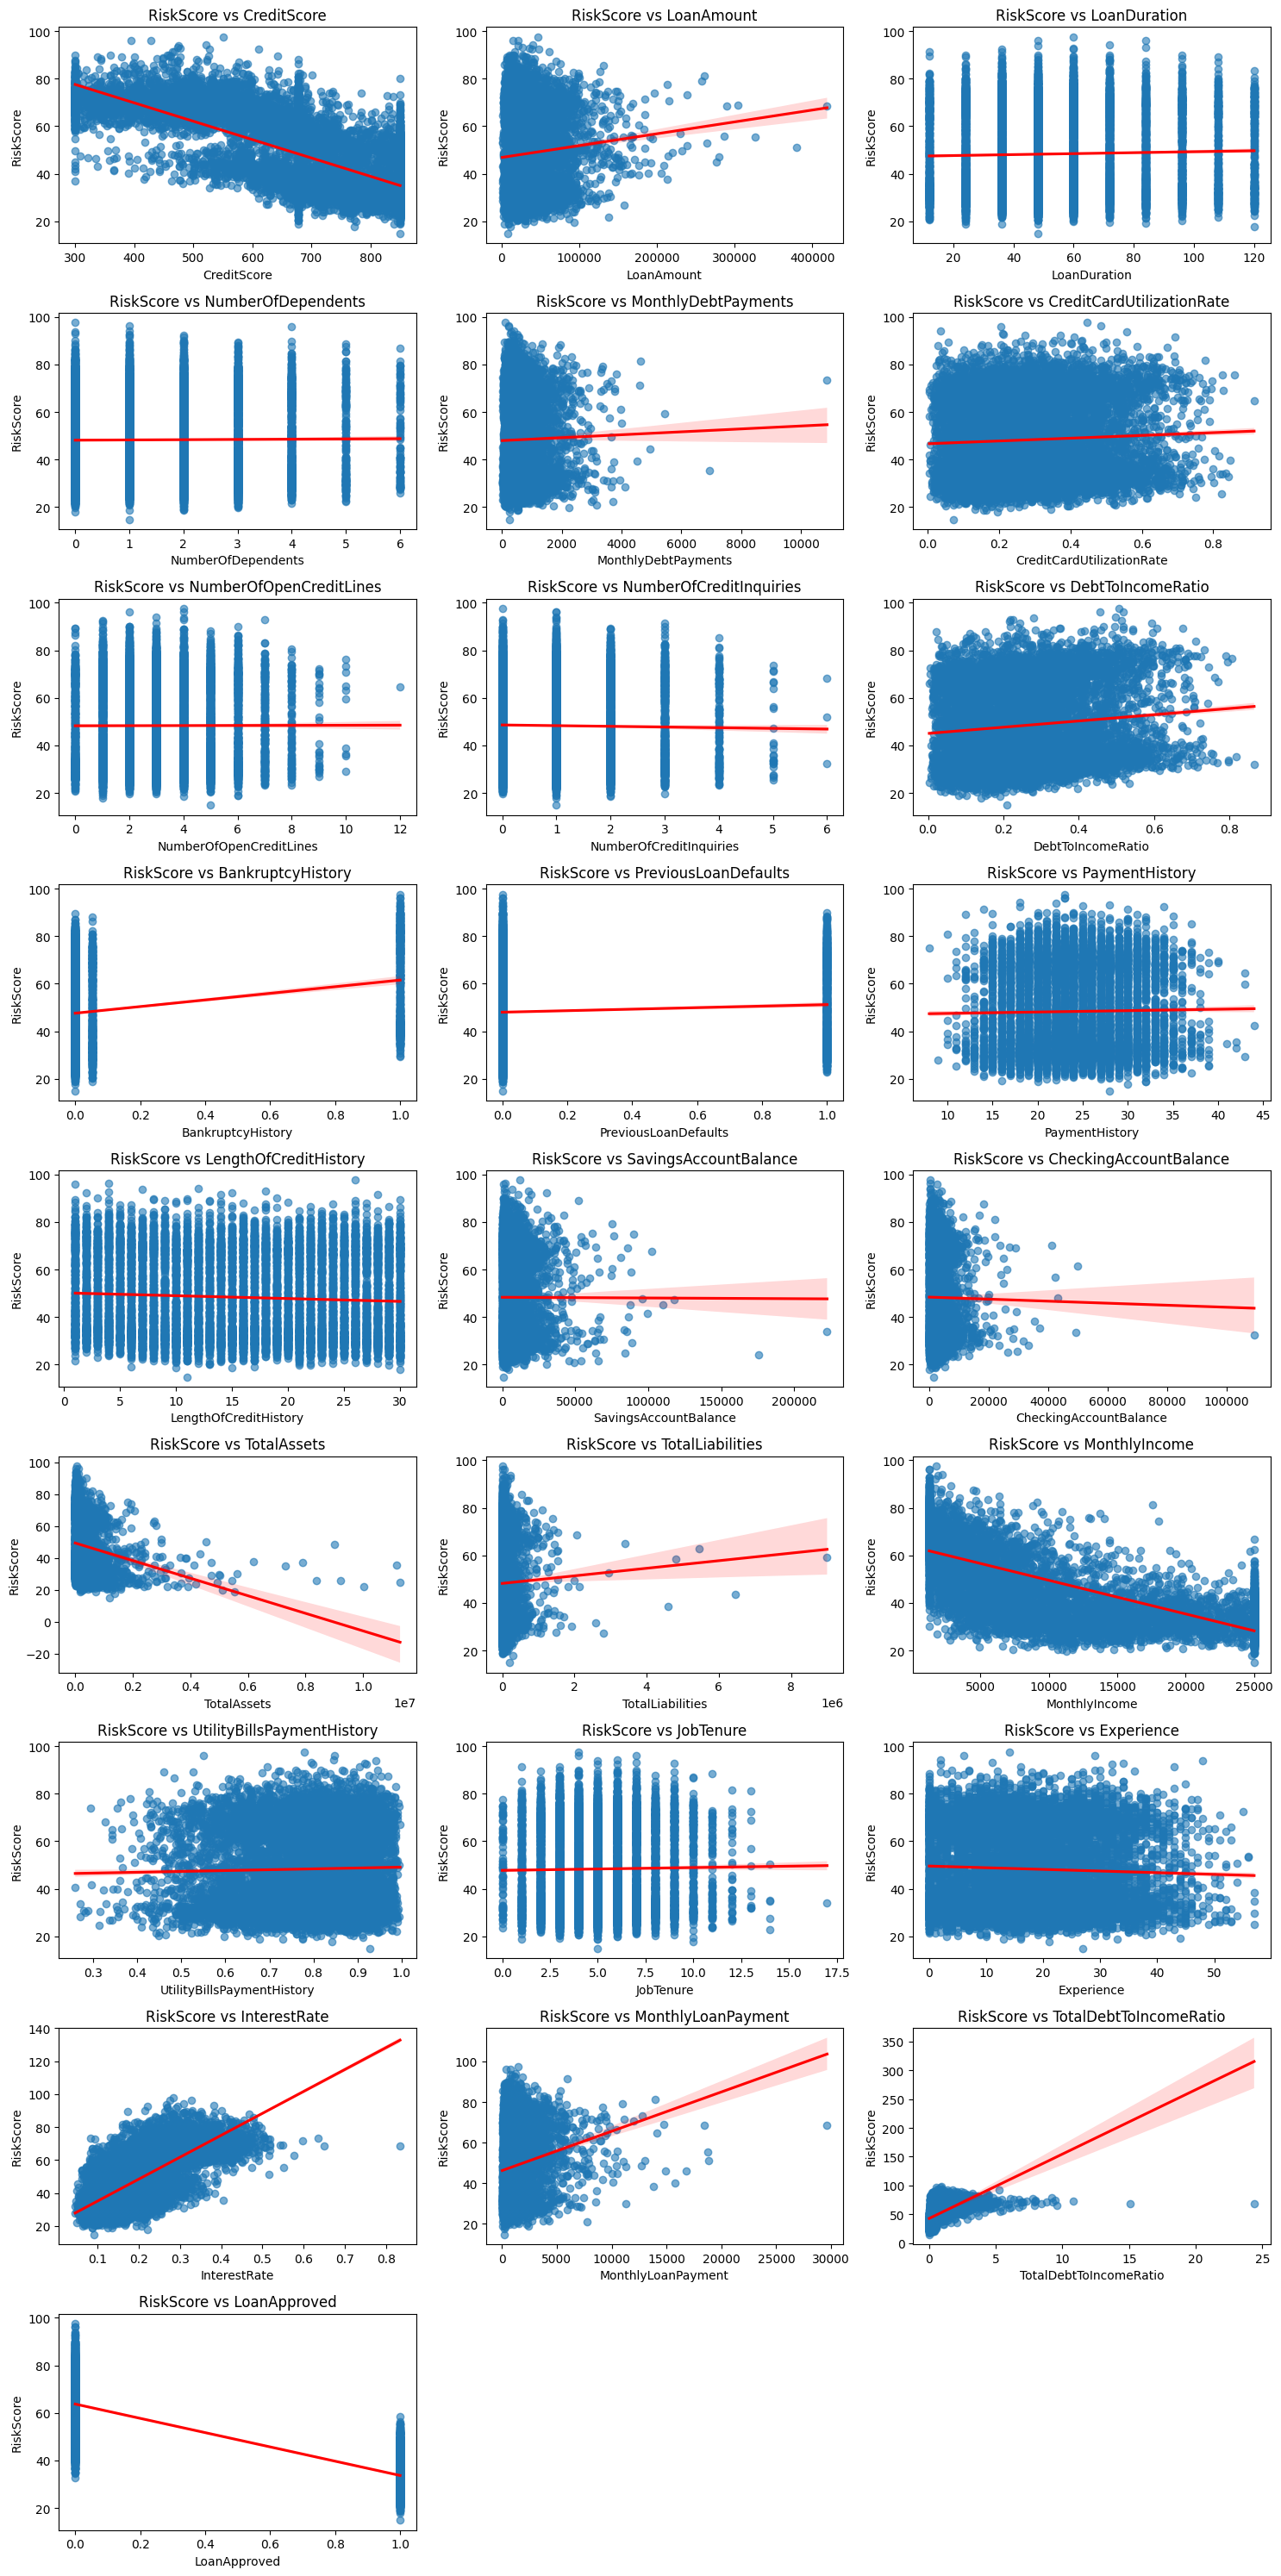

In [73]:
visualize_features_vs_target(copy_train_df)

# Нормализация данных (z-score, min-max).

Z-score

In [74]:
def z_score_normalize(df, columns):
    df_normalized = df.copy()
    for col in columns:
        mean = df[col].mean()
        std = df[col].std()
        df_normalized[col] = (df[col] - mean) / std
    return df_normalized

In [75]:
numeric_cols = copy_train_df.select_dtypes(include=['float64', 'int64']).columns
copy_train_df_z = z_score_normalize(copy_train_df, numeric_cols)
print(copy_train_df_z)

      CreditScore  LoanAmount  LoanDuration  NumberOfDependents  \
0       -0.754378   -0.469507      0.271170           -0.398562   
1        1.004993   -0.513751     -0.709872           -0.398562   
2        1.004993    0.323349     -0.709872           -1.103245   
3        0.987458   -0.398418     -0.219351           -1.103245   
4        1.004993    0.023432     -0.219351            0.306121   
...           ...         ...           ...                 ...   
9995    -1.853253   -0.386457     -0.709872           -0.398562   
9996    -0.614096   -0.838565      1.252211           -1.103245   
9997     1.004993    0.538042      1.252211            0.306121   
9998    -0.000879    0.004239     -1.200392           -1.103245   
9999    -0.169869   -0.559082     -1.690913            1.010804   

      MonthlyDebtPayments  CreditCardUtilizationRate  NumberOfOpenCreditLines  \
0                1.115027                  -0.832958                -0.593585   
1               -0.683367        

In [76]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
copy_train_df_z = copy_train_df.copy()
copy_train_df_z[numeric_cols] = scaler.fit_transform(copy_train_df[numeric_cols])
print(copy_train_df_z)

      CreditScore  LoanAmount  LoanDuration  NumberOfDependents  \
0       -0.754416   -0.469531      0.271183           -0.398582   
1        1.005044   -0.513777     -0.709908           -0.398582   
2        1.005044    0.323366     -0.709908           -1.103301   
3        0.987508   -0.398438     -0.219362           -1.103301   
4        1.005044    0.023433     -0.219362            0.306137   
...           ...         ...           ...                 ...   
9995    -1.853348   -0.386477     -0.709908           -0.398582   
9996    -0.614127   -0.838608      1.252275           -1.103301   
9997     1.005044    0.538070      1.252275            0.306137   
9998    -0.000879    0.004239     -1.200454           -1.103301   
9999    -0.169878   -0.559110     -1.691000            1.010855   

      MonthlyDebtPayments  CreditCardUtilizationRate  NumberOfOpenCreditLines  \
0                1.115084                  -0.833001                -0.593616   
1               -0.683402        

Min-Max

In [77]:
def minmax_normalize(df, columns):
    df_normalized = df.copy()
    for col in columns:
        min_val = df[col].min()
        max_val = df[col].max()
        df_normalized[col] = (df[col] - min_val) / (max_val - min_val)
    return df_normalized

In [79]:
copy_train_df_minmax = minmax_normalize(copy_train_df, numeric_cols)
print(copy_train_df_minmax)

      CreditScore  LoanAmount  LoanDuration  NumberOfDependents  \
0        0.452727    0.038827      0.444444            0.166667   
1        1.000000    0.036003      0.222222            0.166667   
2        1.000000    0.089423      0.222222            0.000000   
3        0.994545    0.043363      0.333333            0.000000   
4        1.000000    0.070284      0.333333            0.333333   
...           ...         ...           ...                 ...   
9995     0.110909    0.044127      0.222222            0.166667   
9996     0.496364    0.015275      0.666667            0.000000   
9997     1.000000    0.103124      0.666667            0.333333   
9998     0.687112    0.069059      0.111111            0.000000   
9999     0.634545    0.033110      0.000000            0.500000   

      MonthlyDebtPayments  CreditCardUtilizationRate  NumberOfOpenCreditLines  \
0                0.099577                   0.162808                 0.166667   
1                0.018222        

In [80]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
copy_train_df_minmax = copy_train_df.copy()
copy_train_df_minmax[numeric_cols] = scaler.fit_transform(copy_train_df[numeric_cols])
print(copy_train_df_minmax)

      CreditScore  LoanAmount  LoanDuration  NumberOfDependents  \
0        0.452727    0.038827      0.444444            0.166667   
1        1.000000    0.036003      0.222222            0.166667   
2        1.000000    0.089423      0.222222            0.000000   
3        0.994545    0.043363      0.333333            0.000000   
4        1.000000    0.070284      0.333333            0.333333   
...           ...         ...           ...                 ...   
9995     0.110909    0.044127      0.222222            0.166667   
9996     0.496364    0.015275      0.666667            0.000000   
9997     1.000000    0.103124      0.666667            0.333333   
9998     0.687112    0.069059      0.111111            0.000000   
9999     0.634545    0.033110      0.000000            0.500000   

      MonthlyDebtPayments  CreditCardUtilizationRate  NumberOfOpenCreditLines  \
0                0.099577                   0.162808                 0.166667   
1                0.018222        

# Метрики

In [81]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error

In [82]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

In [83]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

In [84]:
def r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

In [88]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [89]:
y_true = np.array([3, -0.5, 2, 7])
y_pred = np.array([2.5, 0.0, 2, 8])

print("SK Mean squared error:", mean_squared_error(y_true, y_pred))
print("My Mean squared error:", mse(y_true, y_pred))
print("SK Mean absolute error:", mean_absolute_error(y_true, y_pred))
print("My Mean absolute error:", mae(y_true, y_pred))
print("SK Mean absolute percentage error:", mean_absolute_percentage_error(y_true, y_pred))
print("My Mean absolute percentage error:", mape(y_true, y_pred))
print("SK R2 score:", r2_score(y_true, y_pred))
print("My R2 score:", r2(y_true, y_pred))

SK Mean squared error: 0.375
My Mean squared error: 0.375
SK Mean absolute error: 0.5
My Mean absolute error: 0.5
SK Mean absolute percentage error: 0.3273809523809524
My Mean absolute percentage error: 0.3273809523809524
SK R2 score: 0.9486081370449679
My R2 score: 0.9486081370449679
